In [25]:
import pandas as pd
import env
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import acquire_r
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import sklearn.model_selection
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import logistic_regression_util
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import knn_lesson_util as util
import wrangle
import encode
from sklearn.model_selection import KFold, cross_val_score
import time
import model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from scipy import stats

### Start with acquiring data from SQL database

In [2]:
df = acquire_r.get_data_from_sql()

In [3]:
# check head of the dataset
df.head(4)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check


In [4]:
## check tail of the dataset
df.tail(4)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
7039,2,3,3,9953-ZMKSM,Male,0,No,No,63,Yes,...,No internet service,No internet service,No internet service,No,25.25,1559.3,No,Two year,None,Mailed check
7040,4,3,3,9964-WBQDJ,Female,0,Yes,No,71,Yes,...,No internet service,No internet service,No internet service,Yes,24.40,1725.4,No,Two year,None,Credit card (automatic)
7041,3,3,3,9972-EWRJS,Female,0,Yes,Yes,67,Yes,...,No internet service,No internet service,No internet service,Yes,19.25,1372.9,No,Two year,None,Bank transfer (automatic)
7042,4,3,3,9975-GPKZU,Male,0,Yes,Yes,46,Yes,...,No internet service,No internet service,No internet service,No,19.75,856.5,No,Two year,None,Credit card (automatic)


In [5]:
#check the shape of the dataset
df.shape

(7043, 24)

## Start with looking for missing values  data integrity issues 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
internet_service_type_id    7043 non-null int64
contract_type_id            7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

### Looks like there are no null values in dataset. However the total_charges is an 'object' instead of float. Lets explore it further

In [7]:
df.sort_values(by = 'total_charges')

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
2048,3,1,3,4472-LVYGI,Female,0,Yes,Yes,0,No,...,Yes,Yes,No,Yes,52.55,,No,Two year,DSL,Bank transfer (automatic)
6143,2,3,2,2923-ARZLG,Male,0,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,Yes,19.70,,No,One year,None,Mailed check
1949,3,1,3,2775-SEFEE,Male,0,No,Yes,0,Yes,...,Yes,No,No,Yes,61.90,,No,Two year,DSL,Bank transfer (automatic)
1878,4,1,3,1371-DWPAZ,Female,0,Yes,Yes,0,No,...,Yes,Yes,No,No,56.05,,No,Two year,DSL,Credit card (automatic)
6615,2,3,3,3213-VVOLG,Male,0,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No,25.35,,No,Two year,None,Mailed check
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,2,3,2,8249-THVEC,Male,0,Yes,Yes,51,Yes,...,No internet service,No internet service,No internet service,No,19.40,997.75,No,One year,None,Mailed check
6261,4,3,2,6051-PTVNS,Female,0,Yes,Yes,55,Yes,...,No internet service,No internet service,No internet service,No,19.15,998.1,No,One year,None,Credit card (automatic)
3702,2,2,1,5899-MQZZL,Female,0,No,No,13,Yes,...,No,No,No,Yes,75.00,999.45,Yes,Month-to-month,Fiber optic,Mailed check
3392,4,2,1,4536-PLEQY,Male,0,Yes,No,12,Yes,...,No,No,Yes,Yes,85.05,999.8,No,Month-to-month,Fiber optic,Credit card (automatic)


### Looks like there are 11 rows with no total_charges_values. We decided to remove these 11 datapoints as we have fairly big dataset to work with. 

### Wrangle the dataset and split it into train, validate and test. The wrangle module (wrangle_telco.py ) does the following:

##### Replace spaces with 'NaN'.
##### Drop rows with those NaN values (total of 11 rows)
##### Changes total_charges column values from 'object' to 'float'
##### Changes 'Yes' to 1 and 'No' to 0. 
##### creates a new column 'tenure years' using 'tenure
##### Splits data into train and test (80:20 split). The train dataset is split further (80:20) into train and validate.
##### Random state is set to 42 
***

In [8]:
#using wrangle_telco.py file to wrangle and split the data
train, validate, test = wrangle.wrangle_telco(df)

In [9]:
# confirm the shape of train, validate and test dataset
train.shape, validate.shape, test.shape

((4500, 25), (1125, 25), (1407, 25))

# We will start with exploratory data analysis (EDA) below on the train dataset

In [10]:
train.head(2)

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,tenure_years
5217,4,2,3,3134-DSHVC,Female,0,0,0,63,1,...,1,0,0,98.0,6218.45,0,Two year,Fiber optic,Credit card (automatic),5.0
5496,3,2,3,9586-JGQKH,Female,0,1,0,64,1,...,1,1,1,105.4,6794.75,0,Two year,Fiber optic,Bank transfer (automatic),5.0


In [20]:
train.churn.value_counts()

0    3289
1    1211
Name: churn, dtype: int64

### This seems like a 'unbalanced dataset' where 74% are non-churners and 26% as churners
***

### Let's start with pair plot for continueous variables: tenure, total charges and monthly charges

In [11]:
# create a dataset of continuous variable and 'churn'for 'hue'
train_cont = train[['tenure', 'total_charges', 'monthly_charges','churn']]

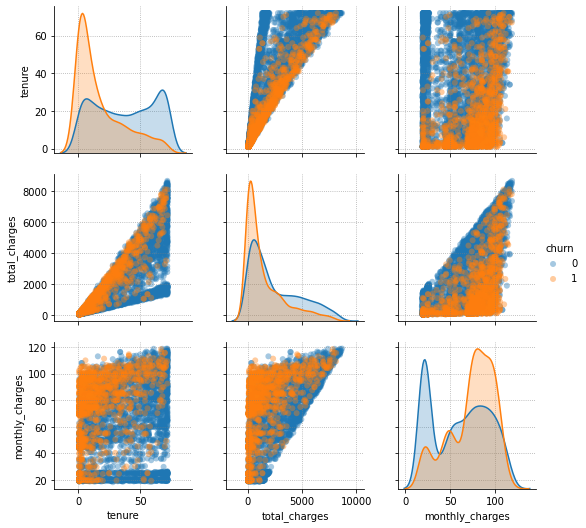

In [12]:
sns.pairplot(train_cont, vars = train_cont.columns[:-1], hue='churn', plot_kws=dict(alpha=.4, edgecolor='none'))

#### The pairplot above implies:
1. Churners seems to have much shorter tenure compared to non-churners
2. Churners might be paying more (or using higher priced services) than non-churners
3. Monthly charges for churners are higher (possibly due to subscription) to higher priced services compared to non-churners

### Lets do a statistical test to see if monthly charges (contineous variable) are different between churners/non-churners (categorical variable). We can do a two sample t-test.

#### $H_0$: There is no difference in monthly charges between churners and non-churners
#### $H_a$: There is difference in monthly charges between churners and non-churners

In [31]:
x1 = train[train.churn ==1].monthly_charges
x2 = train[train.churn ==0].monthly_charges

In [32]:
stats.ttest_ind(x1, x2)

Ttest_indResult(statistic=12.997107440581107, pvalue=6.081507718988995e-38)

### The p value is almost zero. This means that we can reject our null hypothesis which means that there is statistical difference between monthly charges for churners and non-churners
***

### Lets explore if there is any gender relationship with churners

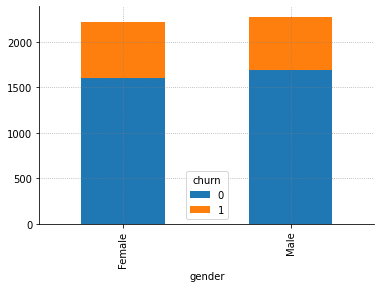

In [13]:
train_gender = pd.crosstab(train.gender, train.churn)
train_gender.plot(kind='bar', stacked=True)

#### It seems like the rate of churn is same between male and females
***


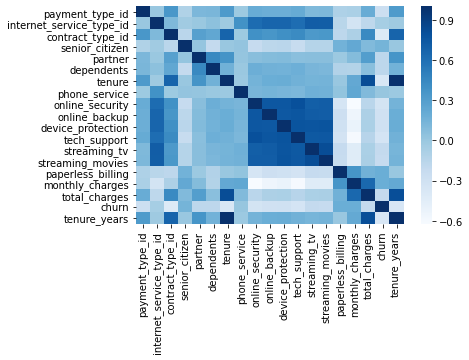

In [14]:
# Lets do a heatmap 
sns.heatmap(train.corr(), cmap='Blues')

### This chart looks too busy. We can just look at table of correlation instead below

In [15]:
corr = train.corr()
corr

,payment_type_id,internet_service_type_id,contract_type_id,senior_citizen,partner,dependents,tenure,phone_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,tenure_years
payment_type_id,1.000000,0.010196,0.355552,-0.103203,0.123602,0.131392,0.331152,-0.012785,0.207083,0.187786,0.184068,0.212969,0.107194,0.116705,-0.094247,-0.083413,0.207307,-0.266530,0.327591
internet_service_type_id,0.010196,1.000000,0.109694,-0.029249,0.004398,0.051347,-0.017016,0.386718,0.621092,0.666058,0.667515,0.618590,0.714865,0.709063,-0.148740,-0.329540,-0.177037,-0.054453,-0.018147
contract_type_id,0.355552,0.109694,1.000000,-0.155734,0.285199,0.235638,0.675999,-0.009143,0.397776,0.362559,0.400807,0.432083,0.335675,0.349069,-0.167396,-0.089372,0.440414,-0.403699,0.674348
senior_citizen,-0.103203,-0.029249,-0.155734,1.000000,0.018139,-0.209509,0.009426,0.027526,-0.215005,-0.162786,-0.154695,-0.227421,-0.133915,-0.130352,0.157127,0.228021,0.103035,0.149408,0.006921
partner,0.123602,0.004398,0.285199,0.018139,1.000000,0.448175,0.375354,0.019449,0.073268,0.088690,0.094374,0.068276,0.073090,0.073642,-0.007685,0.089039,0.307353,-0.169257,0.367897
dependents,0.131392,0.051347,0.235638,-0.209509,0.448175,1.000000,0.165728,-0.000516,0.186705,0.165236,0.159343,0.180574,0.136003,0.124239,-0.112298,-0.119796,0.064202,-0.171815,0.161974
tenure,0.331152,-0.017016,0.675999,0.009426,0.375354,0.165728,1.000000,-0.002991,0.154416,0.192637,0.195737,0.164005,0.144816,0.155948,0.006441,0.230045,0.817362,-0.364808,0.988998
phone_service,-0.012785,0.386718,-0.009143,0.027526,0.019449,-0.000516,-0.002991,1.000000,0.131856,0.150252,0.134244,0.122561,0.175114,0.164008,0.034202,0.243624,0.104611,0.017386,-0.005153
online_security,0.207083,0.621092,0.397776,-0.215005,0.073268,0.186705,0.154416,0.131856,1.000000,0.758825,0.758639,0.800254,0.705387,0.716494,-0.342207,-0.622544,-0.158139,-0.327007,0.154427
online_backup,0.187786,0.666058,0.362559,-0.162786,0.088690,0.165236,0.192637,0.150252,0.758825,1.000000,0.746879,0.760471,0.724159,0.717200,-0.270229,-0.547190,-0.088103,-0.293977,0.193743


In [16]:
# We can look at top 10 features corelated with churn
train.corr().iloc[17].sort_values()[0:10]

contract_type_id    -0.403699
tenure              -0.364808
tenure_years        -0.356645
tech_support        -0.333430
online_security     -0.327007
online_backup       -0.293977
device_protection   -0.289563
payment_type_id     -0.266530
streaming_movies    -0.211497
streaming_tv        -0.209256
Name: churn, dtype: float64

#### We can explore the features identified above as highly correlated with Churn

In [22]:
train.contract_type.value_counts()

Month-to-month    2480
Two year          1081
One year           939
Name: contract_type, dtype: int64

In [29]:
observed = pd.crosstab(train.churn, train.contract_type)
observed

contract_type,Month-to-month,One year,Two year
churn,,,
0,1402,836,1051
1,1078,103,30


### The cross tabulation suggest that month-to-month customers are more likely to churn than those with One or two year contract. We can do a statictical chi2 test to if these two groups are really different

### Null Hypothesis $H_0$ : There is no difference in churn rate between month-to-month and One-year contract customers
### Alternate Hypothesis $H_a$: The churn rate is different  between month-to-month and One-year contract customers


In [30]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed\n')
print(observed.values)
print('---\nExpected\n')
print(expected)
print('---\n')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed

[[1402  836 1051]
 [1078  103   30]]
---
Expected

[[1812.60444444  686.30466667  790.09088889]
 [ 667.39555556  252.69533333  290.90911111]]
---

chi^2 = 787.1229
p     = 0.0000


### The p value is less than 0.05, so we can reject the null hypothesis. This implies that rate of churn in month to month customers is significantly higher than other customers